# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [37]:
!conda install -c conda-forge xgboost
!pip install xgboost

Solving environment: failed

CondaMemoryError: The conda process ran out of memory. Increase system memory and/or try again.

^C
  Using cached https://files.pythonhosted.org/packages/c4/04/32989ec64004dca894f1d3ea4c41b1397272857edf14c1a9d1492b692d2d/xgboost-1.5.2.tar.gz
  Running setup.py bdist_wheel for xgboost ... error
  Complete output from command /opt/conda/bin/python -u -c "import setuptools, tokenize;__file__='/tmp/pip-install-q4rknaxa/xgboost/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /tmp/pip-wheel-1d7q78lb --python-tag cp36:
  /opt/conda/lib/python3.6/distutils/dist.py:261: UserWarning: Unknown distribution option: 'long_description_content_type'
    warnings.warn(msg)
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.linux-x86_64-3.6
  creating build/lib.linux-x86_64-3.6/xgboost
  copying xgboost/dask.py -> build/lib.li

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift



from sklearn.ensemble import AdaBoostRegressor # Adaptive Boosting
from sklearn.ensemble import GradientBoostingRegressor # Gradient Tree Boosting
# from xgboost.sklearn import XGBRegressor # Extreme Gradient Boosting
# !pip install xgboost
# import xgboost as xgb

from sklearn.metrics import roc_auc_score, fbeta_score, accuracy_score, precision_score, recall_score

from scipy import stats
from time import time

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### EDA - Exploration and discovery dataset

In [4]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [5]:
# total number of fields with null - 'naturally'
azdias_null = azdias.isnull().sum()
azdias_null_percent = azdias_null / len(azdias) * 100

#### Missing values 

##### Some fieds have a lot of missing values in this dataset

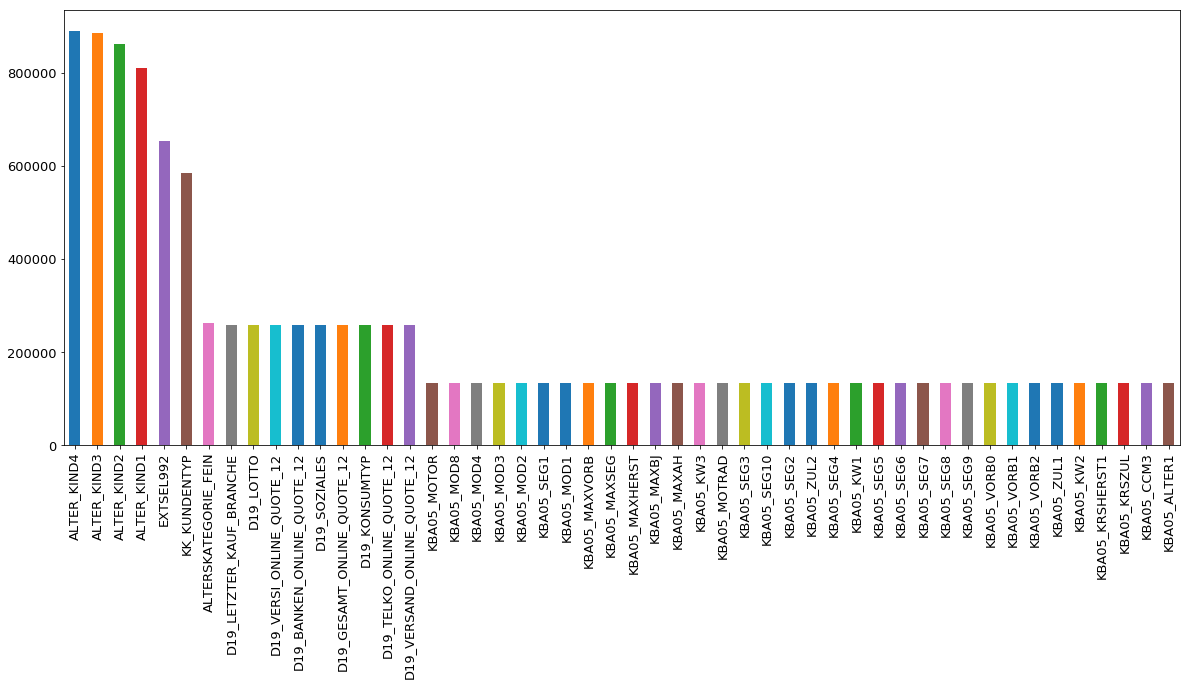

In [6]:
# visualise natually missing data
(azdias_null.sort_values(ascending=False)[:50].plot(kind='bar', figsize=(20,8), fontsize=13))  

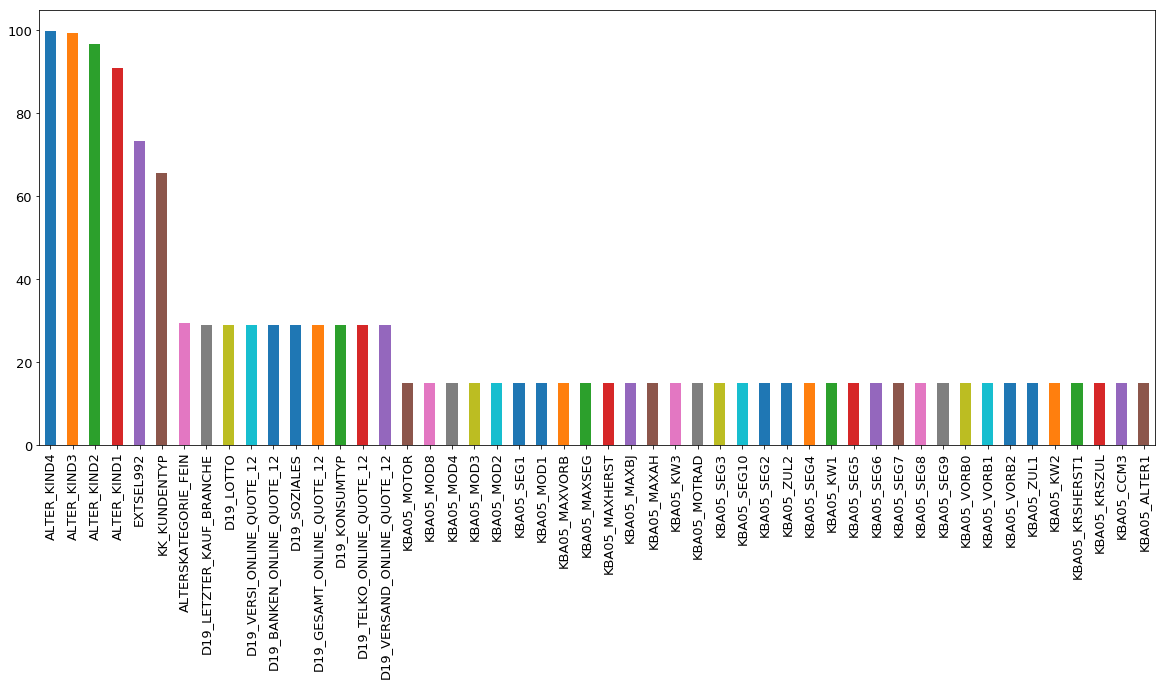

In [7]:
# visualise missing data with percentual
# some columns has almost 100% of missing values
(azdias_null_percent.sort_values(ascending=False)[:50].plot(kind='bar', figsize=(20,8), fontsize=13))  

In [8]:
# let's see this in a slightly different way.
# Calculate percentage of data kept for rows with * or less missing data points
# we can see that around 16% this more or less stagnates and increase in number of columns does not directly increase % of data kept.
# so we will use this as an indicator to help us choose the threshold limit.

print("Percentage of data kept:",round(azdias.isnull().sum(axis=1).value_counts().sort_index().cumsum()[:30]/azdias.isnull().sum(axis=1).shape[0]*100,0))


Percentage of data kept: 0      0.0
1      0.0
2      1.0
3      3.0
4     17.0
5     38.0
6     56.0
7     62.0
8     63.0
9     64.0
10    64.0
11    64.0
12    65.0
13    65.0
14    65.0
15    73.0
16    82.0
17    83.0
18    83.0
19    83.0
20    84.0
21    84.0
22    84.0
23    84.0
24    84.0
25    84.0
26    84.0
27    84.0
28    84.0
29    84.0
dtype: float64


In [ ]:
azdias = azdias[azdias.isnull().sum(axis=1) <= 16].reset_index(drop=True)
print('number of rows in new dataset: ',azdias.shape[0])


In [ ]:
# now we have 6 columns with more than 65% of missing data. let`s drop them
column_nans = azdias.isnull().mean()
drop_cols = azdias.columns[column_nans > 0.65]
print('columns to drop: ', drop_cols)

In [ ]:
print('number of rows in new dataset: ',azdias.shape[0])


In [ ]:
#and now we need to drop extra columns on customers dataset
customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)


In [ ]:
#number of rows in each dataset after drop missing values 
azdias = azdias.drop(drop_cols,axis=1)
customers = customers.drop(drop_cols,axis=1)

print('number of rows in new dataset: ',azdias.shape)
print('number of rows in new dataset: ',customers.shape)

In [ ]:
#here we will drop fiels with many diferentes values... this is not useful to combine customer in groups beacause we dont have important values to describe the group

azdias = azdias.drop(['EINGEFUEGT_AM'],axis=1)
customers = customers.drop(['EINGEFUEGT_AM'],axis=1)

azdias = azdias.drop(['D19_LETZTER_KAUF_BRANCHE'],axis=1)
customers = customers.drop(['D19_LETZTER_KAUF_BRANCHE'],axis=1)




In [ ]:
%%time
# introducing this new clean up step - as without this we end up with 406 columns after one-hot encoding
# reduce number of columns further by trying to removing highly correlated columns
# idea and approach from Chris Albon's website https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/


# find correlation matrix    
corr_matrix = azdias.corr().abs()
upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# identify columns to drop based on threshold limit
drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]
# drop columns from azdias
azdias = azdias.drop(drop_columns, axis=1)
print('number of columns', len(azdias.columns))

# repeat for customers
# find correlation matrix    
corr_matrix = customers.corr().abs()
upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# identify columns to drop based on threshold limit
drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]
# drop columns from azdias
customers = customers.drop(drop_columns, axis=1)
print('number of columns', len(customers.columns))

In [ ]:
# before going ahead with encoding we need to find categorical fields - below 1 hack option to do it

cols = azdias.columns
num_cols = azdias._get_numeric_data().columns
print('num_cols: ',num_cols)
print('categorical: ',list(set(cols) - set(num_cols)))

In [ ]:
# we need to fill missing values here. We will fill missing values with -1 indicating unknown as in the description.

azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
azdias[['CAMEO_DEU_2015','OST_WEST_KZ']]=azdias[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)
customers[['CAMEO_DEU_2015','OST_WEST_KZ']]=customers[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)

In [ ]:
# fillna with 9 for fields that has 9 marked as unknown

azdias[azdias.columns[(azdias==9).any()]] = azdias[azdias.columns[(azdias==9).any()]].fillna(9)
customers[customers.columns[(customers==9).any()]] = customers[customers.columns[(customers==9).any()]].fillna(9)

In [ ]:
azdias[azdias.columns[(azdias==0).any()]] = azdias[azdias.columns[(azdias==0).any()]].fillna(0)
customers[customers.columns[(customers==0).any()]] = customers[customers.columns[(customers==0).any()]].fillna(0)

# fillna with -1 for fields that has 0 marked as unknown

azdias[azdias.columns[(azdias==-1).any()]] = azdias[azdias.columns[(azdias==-1).any()]].fillna(-1)
customers[customers.columns[(customers==-1).any()]] = customers[customers.columns[(customers==-1).any()]].fillna(-1)

In [ ]:
#with  all null data now handled, we should focus on getting objects/categorical variables to numbers via one hot encoding

azdias = pd.get_dummies(azdias)
customers = pd.get_dummies(customers)

In [ ]:
azdias_columns = azdias.columns
customers_columns = customers.columns

# impute nans using mode value

imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)

azdias = imputer.fit_transform(azdias)
azdias = pd.DataFrame(azdias)
print('imputed azdias: ', azdias.head(5))

customers = imputer.fit_transform(customers)
customers = pd.DataFrame(customers)
print('imputed customers: ', customers.head(5))

In [ ]:
azdias = azdias.astype(int)
customers = customers.astype(int)

In [ ]:
# detect and exclude outliers in dataframe
# as mentioned in https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame

azdias = azdias[(np.abs(stats.zscore(azdias)) < 6).all(axis=1)]
customers = customers[(np.abs(stats.zscore(customers)) < 6).all(axis=1)]

### Standardize features by removing the mean and scaling to unit variance


In [ ]:
# scale the data
scale = StandardScaler(copy=False)

#scale = MinMaxScaler(copy=False)
azdias[azdias.columns] = scale.fit_transform(azdias)

In [ ]:
azdias.columns = azdias_columns
customers[customers.columns] = scale.fit_transform(customers)
azdias.to_pickle('azdias_scaled')
customers.to_pickle('customers_scaled')



In [ ]:
def data_preprocess_2(df, for_clustering, df_name=None):
    
    if for_clustering:
        if df_name == 'azdias':
            df = df[df.isnull().sum(axis=1) <= 16].reset_index(drop=True)
        elif df_name == 'customers':            
            df.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)
        
    #column_nans = df.isnull().mean()
    drop_cols = ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992','KK_KUNDENTYP']
    
    df = df.drop(drop_cols,axis=1)
    df = df.drop(['EINGEFUEGT_AM'],axis=1)
    df = df.drop(['D19_LETZTER_KAUF_BRANCHE'],axis=1)


    # find correlation matrix    
    corr_matrix = df.corr().abs()
    upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # identify columns to drop based on threshold limit
    drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]
    # drop columns from df
    df = df.drop(drop_columns, axis=1)
    print('shape after corr', df.shape)


    # we need to fill missing values here. We will fill missing values with -1 indicating unknown as in the description.
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
    df[['CAMEO_DEU_2015','OST_WEST_KZ']]=df[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)



    # fillna with 9 for fields that has 9 marked as unknown
    df[df.columns[(df==9).any()]] = df[df.columns[(df==9).any()]].fillna(9)

    # fillna with 0 for fields that has 0 marked as unknown
    df[df.columns[(df==0).any()]] = df[df.columns[(df==0).any()]].fillna(0)

    # fillna with -1 for fields that has 0 marked as unknown
    df[df.columns[(df==-1).any()]] = df[df.columns[(df==-1).any()]].fillna(-1)


    
    #print('col name before: ', df.columns)
    #with  all null data now handled, we should focus on getting objects/categorical variables to numbers via one hot encoding
    df = pd.get_dummies(df)
    #print('col name after: ', df.columns)
    print('shape after one-hot', df.shape)
    
    df_columns = list(df.columns.values)

    # impute nans using mode value
    imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)
    df = imputer.fit_transform(df)
    df = pd.DataFrame(df)
    #print('imputed dataframe: ', df.head(5))
    print('shape after impute', df.shape)
    
    
    
    # convert to int
    df = df.astype(int)


    # detect and exclude outliers in dataframe
    # as mentioned in https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
    #  remove all rows that have outliers in at least one column   
    if for_clustering:
        print('inside outliers if')
        df = df[(np.abs(stats.zscore(df)) < 6).all(axis=1)] 
        print('shape before scaling', df.shape)
    # scale the data
    scale = StandardScaler(copy=False)
    scaled = scale.fit_transform(df)
    df = pd.DataFrame(scaled,columns= df_columns)
    print('shape after scaling', df.shape)
    #else:
    #    df.columns = df_columns
        
    df = df.set_index('LNR')
    return df

In [ ]:
#cleaning

azdias = data_preprocess_2(azdias, True, 'azdias')
print(azdias.shape)
print(azdias.head(5))

In [ ]:
# clean customers
customers = data_preprocess_2(customers, True, 'customers')
print(customers.shape)
print(customers.head(5))

In [ ]:
customers.head(5)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

After data preprocessing step we could find that general population data (azdias) now has 415405 rows and 283 columns. Even though we have dropped not-so important features and outlier data, this is still high dimensional data and this is where we will be using Principal Component to reduce dimension.

In [ ]:
%%time
pca = PCA().fit(azdias)
plt.figure(figsize=(20,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [ ]:
def print_weights(n):
    '''
    n: number of principal component
    '''
    components = pd.DataFrame(np.round(pca.components_[n - 1: n], 4), columns = azdias.keys())
    components.index = ['Weights']
    components = components.sort_values(by = 'Weights', axis = 1, ascending=False)
    components = components.T
    print(components)
    return components

In [ ]:
#with PCA our goal is reduce the dimension and t to make our data has high variance

def reduce_data(df,n=220):
    pca = PCA(n_components=n).fit(df)
    reduced_data = pca.transform(df)
    reduced_data = pd.DataFrame(reduced_data)
    print(pca.explained_variance_ratio_.sum())
    return reduced_data

In [ ]:
reduced_azdias = reduce_data(azdias)
reduced_customers = reduce_data(customers)

print('number of rows in new dataset: ',reduced_azdias.shape)
print('number of rows in new dataset: ',reduced_customers.shape)

### Clustering

Now, we can run a clustering proccess to create similar groups of customers

In [ ]:
def score(data, k):
    kmeans_k = KMeans(k)
    model_k = kmeans_k.fit(data)
    return abs(model_k.score(data))

In [ ]:
centers = np.linspace(1,21,21)
centers

In [ ]:
scores = []
for i in range(1, 21):
    scores.append(score(reduced_azdias.sample(20000), i))
centers = np.linspace(1,20,20)
plt.plot(centers, scores, linestyle='-', marker='o', color='orange')

In [ ]:
centers = np.linspace(1,20,20)
plt.figure(figsize=(14,6))
plt.plot(centers, scores, linestyle='-', marker='o', color='orange')
plt.xticks(list(range(1,22,2)))
plt.ylabel('Average Within-Cluster Distances')
plt.xlabel('Number of Clusters')

around 12, the distance is almost flatten, so for this cluestering we will choice 12 groups

In [ ]:
kmeans_k = KMeans(12)
model_k = kmeans_k.fit(reduced_azdias)
prediction_azdias = model_k.predict(reduced_azdias)

In [ ]:
azdias_clustered = pd.DataFrame(prediction_azdias, columns = ['Cluster'])
azdias_clustered.to_pickle('azdias_clustered')

In [ ]:
prediction_customers = model_k.predict(reduced_customers)
customers_clustered = pd.DataFrame(prediction_customers, columns = ['Cluster'])
customers_clustered.to_pickle('customers_clustered')

### Analysis and compare

In [ ]:
# Count number of predictions for each customer segment# Count n 
customer_clusters = pd.Series(prediction_customers)
cc = customer_clusters.value_counts().sort_index()
# Count number in each population segment
population_clusters = pd.Series(prediction_azdias)
pc = population_clusters.value_counts().sort_index()

In [ ]:
# Create a dataframe from population and customer segments
df_stat = pd.concat([pc, cc], axis=1).reset_index()
df_stat.columns = ['cluster','population','customer']

df_stat['difference'] = (df_stat['customer']/df_stat['customer'].sum()*100) - (df_stat['population']/df_stat['population'].sum()*100)
df_stat

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
# Add ratio and ratio difference for each cluster to the dataframe
df_stat['pop_percent'] = (df_stat['population']/df_stat['population'].sum()*100).round(2)
df_stat['cust_percent'] = (df_stat['customer']/df_stat['customer'].sum()*100).round(2)


fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(111)
ax = df_stat['pop_percent'].plot(x=df_stat['cluster'],width=-0.3,align='edge',color='blue',kind='bar',position=0)
ax = df_stat['cust_percent'].plot(kind='bar',color='orange',width = 0.3, align='edge',position=1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Ratio %', fontsize=15)
ax.xaxis.set(ticklabels=range(20))
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.margins(x=0.5,y=0.1)

plt.legend(('Gen Population', 'Customer'),fontsize=15)
plt.title(('Ratio of Gen Population Vs Customer segments as % of total per cluster'))
plt.show()

In [ ]:
# Show Highest Positive and Negative weights when a PComponent and Weight is passed
def pca_weights(pc,weight_num):
    
    ratio = pd.DataFrame(pca.explained_variance_ratio_,columns = ['EXPLAINED_VARIANCE'])
    ratio = ratio.round(3)
    weights = pd.DataFrame(pca.components_, columns = azdias.columns.values)
    weights = weights.round(3)    
    
    result = pd.concat([ratio, weights], axis = 1,  join_axes=[ratio.index])
    result[:5]
    print("Principal Component: ", (pc))    
    print('\n')
    print("Highest Positive weights:")
    print(result.iloc[(pc)-1].sort_values(ascending=False)[:weight_num])
    print('\n')
    print("Negative weights:")
    print(result.iloc[(pc)-1].sort_values()[:weight_num])

In [ ]:
# Show highest positive and negative weights for 5 cluster (over representation of Customer)
pca_weights(5,5)

In [ ]:
# Show lowest positive and negative weights for 10 cluster (under representation of Customer)
pca_weights(10,5)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [ ]:
X = mailout_train.drop('RESPONSE',axis=1)
y = mailout_train['RESPONSE']

In [ ]:
df_mailout_train  = data_preprocess_2(X, False)


In [ ]:
df_mailout_train.shape


In [ ]:
y.shape


In [ ]:
df_mailout_train.head(5)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_mailout_train, y, stratify=y, test_size=0.2, random_state=42)


In [ ]:
!pip install xgboost


In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)

In [ ]:
preds = xg_reg.predict(X_val)


In [ ]:
preds

In [ ]:
print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds)))


### Model Evaluation and Validation


In [ ]:
def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train, y_train)
    end = time() # Get end time
    
    # TODO: Calculate the training time
    #results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    # print('unique predictions_train: ', set(predictions_train))
    
    # TODO: Calculate the total prediction time
    #results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    #results['acc_train'] = accuracy_score(y_train, predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    #results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    #results['prec_train'] = precision_score(y_train, predictions_train)
    #results['recall_train'] = recall_score(y_train, predictions_train)
    
    #results['prec_test'] = precision_score(y_test, predictions_test)
    #results['recall_test'] = recall_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    #results['f_train'] = fbeta_score(y_train, predictions_train, beta=1)
        
    # TODO: Compute F-score on the test set which is y_test
    #results['f_test'] = fbeta_score(y_test, predictions_test, beta=1)
       
    # Success
    #print("{} trained on samples.".format(learner.__class__.__name__))
    
    #results['roc'] = roc_auc_score(y_test, predictions_test)
    
    roc = roc_auc_score(y_test, predictions_test)
        
    # Return the results
    return roc

In [ ]:
# Initialize 5 stratified folds
skf = StratifiedKFold(n_splits=5, random_state=42)
skf.get_n_splits(X, y)

In [ ]:
alg_abr = AdaBoostRegressor(random_state=42)
alg_gbr = GradientBoostingRegressor(random_state=42)
alg_xgb = XGBRegressor(random_state=42)


result_list = []
for alg in [alg_1, alg_2, alg_3]:
    alg_name = alg.__class__.__name__
    
    
    
    j=0
    for train_index, val_index in skf.split(df_mailout_train, y):
    
        j+=1
        #print('Fold {}...'.format(j))
        result = {}  
        result['alg_name'] = alg_name
        result['fold']  =  j
        # Split the data into training and test sets
        X_train, X_val = df_mailout_train.iloc[train_index], df_mailout_train.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        
        
        result['roc'] = train_predict(alg, X_train, y_train, X_val, y_val)
        result_list.append(result)
        print (result)
    
#return result_list    

print('result_list: ', result_list)

In [ ]:
df_scores = pd.DataFrame(result_list)


In [ ]:
#compare the models score
df_scores.groupby('alg_name')['roc'].mean()


In [ ]:
#final model
clf_final = xgb.XGBRegressor(
    objective = 'binary:logistic',
    max_depth = 5,
    min_child_weight = 2,
    learning_rate = 0.01,    
    reg_alpha = 0.05,
    subsample = 0.6,
    colsample_bytree = 0.7,
    gamma = 0.2,    
    scale_pos_weight = 1,
    random_state = 42,
    n_estimators = 500,
    scoring = 'roc_auc')

preds = clf_final.fit(X_train,y_train)
predictions_test = preds.predict(X_val)
print(roc_auc_score(y_val, predictions_test))

In [ ]:
#feature importance
feat_importance = clf_final.feature_importances_
feat_importance

In [ ]:
num_feat = 5

indices = np.argsort(feat_importance)[::-1]
columns = X_train.columns.values[indices[:num_feat]]
values = feat_importance[indices][:num_feat]

#print((indices))
print(columns)
print(values)

plt.title('Feature Importances')
plt.barh(np.arange(num_feat), values, color='b', align='center', label = "Feature Weight")
#plt.barh(np.arange(num_feat), np.cumsum(values), color='b', align='center',label = "Cumsum Weight")


plt.yticks(np.arange(num_feat), columns)
plt.xlabel('Relative Importance')
plt.show()

#for name, importance in zip(X_train.column, feat_importance):
#    print(name, "=", importance)